<a href="https://colab.research.google.com/github/nickname8888/sarcasm-classfier/blob/main/nlp_sarcasm_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences # for pre-processing step, padding sentences to the length of the largest sentence

In [2]:
# Defining key variables

vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [3]:
# Getting the sarcastic news dataset

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2022-02-14 05:42:56--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.97.128, 142.251.107.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2022-02-14 05:42:56 (161 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [4]:
# dataset exists in json. Converting the dataset to python lists. 

with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [5]:
# train test split, without shuffle ofc.

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [6]:
# Tokenizing all the words
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

# getting word indices
word_index = tokenizer.word_index

# creating testing and training sequences separately 
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [7]:
# converting to numpy arrays, regular lists did not work. 

import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [8]:
# defining the sequential model. 

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']) # adam for faster training. 

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [10]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 3s - loss: 0.6732 - accuracy: 0.5645 - val_loss: 0.6189 - val_accuracy: 0.6822 - 3s/epoch - 5ms/step
Epoch 2/30
625/625 - 2s - loss: 0.4775 - accuracy: 0.8055 - val_loss: 0.4036 - val_accuracy: 0.8384 - 2s/epoch - 3ms/step
Epoch 3/30
625/625 - 2s - loss: 0.3287 - accuracy: 0.8713 - val_loss: 0.3623 - val_accuracy: 0.8487 - 2s/epoch - 4ms/step
Epoch 4/30
625/625 - 2s - loss: 0.2704 - accuracy: 0.8947 - val_loss: 0.3466 - val_accuracy: 0.8557 - 2s/epoch - 4ms/step
Epoch 5/30
625/625 - 2s - loss: 0.2340 - accuracy: 0.9089 - val_loss: 0.3448 - val_accuracy: 0.8574 - 2s/epoch - 4ms/step
Epoch 6/30
625/625 - 2s - loss: 0.2061 - accuracy: 0.9220 - val_loss: 0.3473 - val_accuracy: 0.8556 - 2s/epoch - 4ms/step
Epoch 7/30
625/625 - 2s - loss: 0.1846 - accuracy: 0.9323 - val_loss: 0.3704 - val_accuracy: 0.8477 - 2s/epoch - 4ms/step
Epoch 8/30
625/625 - 2s - loss: 0.1669 - accuracy: 0.9384 - val_loss: 0.3750 - val_accuracy: 0.8511 - 2s/epoch - 4ms/step
Epoch 9/30
625/625 - 2s 

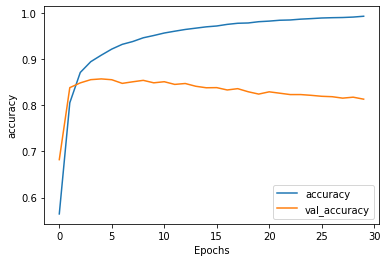

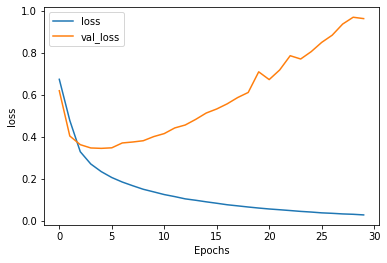

In [11]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [30]:
# checking the model performance on our random sentences. 

sentence = ["The fear of Spider monkeys is taking over the planet", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(np.array(model.predict(padded)))

[[3.6107508e-09]
 [8.2088867e-05]]
